In [91]:
from loica import *
from flapjack import *

import matplotlib.pyplot as plt
import numpy as np
import getpass
import datetime
import random as rd
import pandas as pd

from numpy.fft import fft, ifft, fftfreq
from scipy.interpolate import interp1d, UnivariateSpline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_absolute_error


In [2]:
import seaborn as sns

In [3]:
def random_profile(t0, tmax, nt, fmax):
    freqs = fftfreq(nt)
    tff = np.zeros((nt,), dtype=np.complex)
    ncomps = len(freqs[np.abs(freqs)<fmax])
    tff[np.abs(freqs)<fmax] = np.random.normal(size=(ncomps,)) + np.random.normal(size=(ncomps,))*1j
    profile = ifft(tff).real
    profile = (profile - profile.min()) / (profile.max() - profile.min())
    t = np.linspace(t0, tmax, nt)
    return interp1d(t, profile)

def spline_profile(t0, tmax, nst):
    st = np.linspace(t0, tmax, nst)
    y = np.random.uniform(size=st.shape)
    profile = UnivariateSpline(st, y-y.min(), s=0)
    return profile

def gaussian_profile(t0, tmax, nt, n_blobs):
    t = np.linspace(t0, tmax, nt)
    profile = np.zeros_like(t)
    means = np.linspace(t.min(), t.max(), n_blobs)
    vars = [t.max()/n_blobs]*n_blobs #res.x[:n_blobs]
    heights = np.random.lognormal(size=(n_blobs,))
    for mean,var,height in zip(means, vars, heights):
        gaussian = height * np.exp(-(t-mean)*(t-mean) / var / 2) / np.sqrt(2 * np.pi * var)
        profile += gaussian
    return interp1d(t, profile/profile.max())

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 0.5)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 0.5)

In [4]:
num_iterations = 100 # Number of iterations to run
starting_seed = 0 # Starting value for the seed to use
num_noise_values = 3 # How many different noises you want to test

In [5]:
noise_list = [1e-1, 1e-2, 1e-3, 1e-4]

In [8]:
fj = Flapjack(url_base='flapjack.rudge-lab.org:8000')
#fj = Flapjack(url_base='localhost:8000')
fj.log_in(username=input('Flapjack username: '), password=getpass.getpass('Password: '))

Flapjack username: Gonza10V
Password: ········


In [88]:
study = fj.get('study', name='Loica testing')
if len(study):
    fj.delete('study', study.id[0])

If you are sure you want to delete study with id=71 type "yes"yes


### Constitutive gene

In [10]:
dna = fj.get('dna', name='Const_1e-3_nsr_blob')
if len(dna)==0:
    dna = fj.create('dna', name='Const_1e-3_nsr_blob')
vector = fj.get('vector', name='Const_1e-3_nsr_blob')    
if len(vector)==0:
    vector = fj.create('vector', name='Const_1e-3_nsr_blob', dnas=dna.id)
    
const = GeneticNetwork(vector=vector.id[0])

In [11]:
sfp1 = fj.get('signal', name='SFP0')
sfp1 = Reporter(name='CFP', degradation_rate=0, init_concentration=0, signal_id=sfp1.id[0])

const.add_reporter(sfp1)

In [12]:
#def profile(t):
#    return 1 - gompertz_growth_rate(t, 0.01, 1, 1, 4)
#profile = random_profile(t0=0, tmax=24, nt=100, fmax=0.025)
#profile = spline_profile(t0=0, tmax=24, nst=20)
profile = gaussian_profile(t0=0, tmax=24, nt=100, n_blobs=20)
const.add_operator(Source(output=sfp1, rate=1, profile=profile))

100


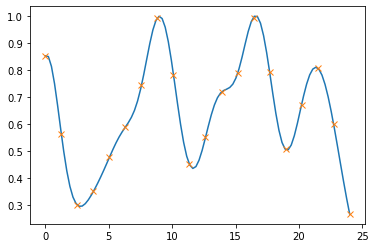

In [13]:
t = np.linspace(0, 24, 100)
plt.plot(t, profile(t))
st = np.linspace(0, 24, 20)
plt.plot(st, profile(st), 'x')
print(len(profile(t)))

In [14]:
print(profile(t))

[0.85287849 0.85039196 0.81382413 0.75004237 0.66901304 0.58169687
 0.49803118 0.42549231 0.36847033 0.32840584 0.30444361 0.29429582
 0.29506113 0.30385385 0.31820234 0.33623988 0.35673335 0.37899074
 0.4026816  0.4276067  0.45346705 0.47969663 0.50542678 0.52962913
 0.55143537 0.57056291 0.58770711 0.60472593 0.62446764 0.65018687
 0.68463571 0.72905772 0.78239463 0.84099422 0.89897688 0.94921526
 0.98468143 0.9997991  0.99145324 0.95944646 0.90638436 0.83713227
 0.75805359 0.67620792 0.59860596 0.53154784 0.48005175 0.44740155
 0.43486998 0.44167187 0.46516256 0.5012432  0.54490037 0.59081092
 0.63397112 0.67033082 0.6973964  0.71471189 0.72406902 0.72928628
 0.73547168 0.7478369  0.77030851 0.80430653 0.84806588 0.89674244
 0.94331171 0.98002198 1.         0.99859071 0.97414055 0.92814102
 0.86483868 0.79051408 0.71262011 0.63889456 0.57649346 0.53117802
 0.50662673 0.50398994 0.52180444 0.55631942 0.60217351 0.65326082
 0.70358099 0.74790273 0.78215894 0.80358659 0.8106837  0.8030

In [15]:
metab = SimulatedMetabolism(biomass, growth_rate)
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

samples = []
for i in range(5):
    sample = Sample(circuit=const, 
                    metabolism=metab,
                    media=media.id[0],
                    strain=strain.id[0])
    samples.append(sample)

In [16]:
print(sample.biomass)

<function biomass at 0x7f936eed0c10>


In [17]:
biomass_signal = fj.get('signal', name='OD')
print(biomass_signal)
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica constitutive expression (no noise)',
              description='Simulated constitutive gene generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=1e-3)

   id name description  color
0   5   OD   OD600:600  black


<AxesSubplot:xlabel='Time'>

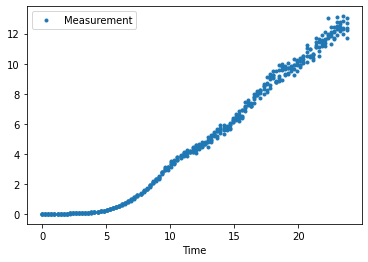

In [18]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', style='.', ax=ax)

In [19]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Testing')
assay.upload(fj, study.id[0])

In [20]:
vector = fj.get('vector', name='Const_1e-3_nsr_blob')
media = fj.get('media', name='Loica')
strain = fj.get('strain', name='Loica strain')
cfp = fj.get('signal', name='SFP0')
biomass_signal = fj.get('signal', name='OD')
print(biomass_signal)

source = Source(None, 0) #const.operators[0]
source.characterize(
    fj,
    vector=vector.id,
    media=media.id,
    strain=strain.id,
    signal=cfp.id,
    biomass_signal=biomass_signal.id,
    n_gaussians=20,
    epsilon=0
)

   id name description  color
0   5   OD   OD600:600  black


100%|██████████| 100/100 [00:00<00:00, 284.12it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 313.70it/s]


Returning dataframe


In [21]:
er_indirect = fj.analysis(media=media.id, 
                    strain=strain.id,
                    vector=[vector.id[0]],
                    type='Expression Rate (indirect)',
                    biomass_signal=biomass_signal.id,
                    eps_L=1e-6,
                    pre_smoothing=11,
                    post_smoothing=11,
                    #bg_correction=2,
                    #min_biomass=0.05,
                    #remove_data=False
                      )
er_direct = fj.analysis(media=media.id, 
                    strain=strain.id,
                    vector=[vector.id[0]],
                    type='Expression Rate (direct)',
                    biomass_signal=biomass_signal.id,
                    eps_L=1e-6,
                    pre_smoothing=11,
                    post_smoothing=11,
                    #bg_correction=2,
                    #min_biomass=0.05,
                    #remove_data=False
                      )

100%|██████████| 100/100 [00:01<00:00, 59.41it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 92.91it/s]


Returning dataframe


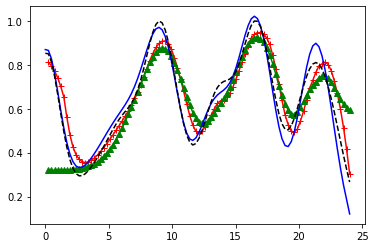

In [22]:
indirect = er_indirect[er_indirect.Signal=='SFP0'].groupby('Time').Rate.mean().values
direct = er_direct[er_direct.Signal=='SFP0'].groupby('Time').Rate.mean().values
plt.plot(t[1:], indirect / 0.24, 'r-+')
plt.plot(t[1:], direct, 'g^-')
plt.plot(t, source.profile(t)*source.rate, 'b')
plt.plot(t, profile(t)/profile(t).max(), 'k--')

CV: Profiles are created. Code by GV.

In [23]:
LOICA_profile = source.profile(t) * source.rate
true_profile = profile(t)/profile(t).max()

In [24]:
# mean_square_error(y_true, y_pred)
mse_indirect = mean_squared_error(true_profile[1:], indirect)
mse_indirect

0.2618743262560913

In [25]:
mse_direct = mean_squared_error(true_profile[1:], direct)
mse_direct

0.0175280343090656

In [26]:
mse_gaussian = mean_squared_error(true_profile[1:], LOICA_profile[1:])
mse_gaussian

0.0021815939958581905

CV: A csv data file is created, using date for an easier identification

In [ ]:

column1 = "Indirect method MSE"
column2 = "Direct method MSE"
column3 = "Gaussian method MSE"
with open("characterization_data_" + datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S") + ".csv", "w", newline="") as cdt:
    fieldnames = [column1, column2, column3]
    writer = csv.DictWriter(cdt, fieldnames = fieldnames)
    writer.writeheader()
    writer.writerow({column1: mse_indirect, column2: mse_direct, column3: mse_gaussian})

In [105]:
#Defined data structure
columns = { 'Profile':[], 'nsr':[], 'Iteration':[], 'Method':[], 'Metric':[], 'Score':[], 'Data_true_profile':[], 'Data_method_profile':[] }
df_characterization = pd.DataFrame(columns)

In [106]:
profiles = ['random', 'spline', 'gaussian']
methods = ['indirect', 'direct', 'loica']
nsr = [1e-2, 1e-3]
metrics = ['explained variance', 'MAE', 'MSE', 'mean_poisson', 'mean_gamma']
#metrics = ['explained variance', 'MAE', 'MSE', 'mean_poisson', 'mean_gamma']

In [107]:
#DNA and Vector are created inside the loop
metab = SimulatedMetabolism(biomass, growth_rate)

sfp1 = fj.get('signal', name='SFP0')
sfp1 = Reporter(name='CFP', degradation_rate=0, init_concentration=0, signal_id=sfp1.id[0])

media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
    
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
biomass_signal = fj.get('signal', name='OD')

study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Testing')

In [ ]:
for p in profiles:
    for n in nsr:
        for i in range(100):
            #create the profile
            if p == 'random':
                profile = random_profile(t0=0, tmax=24, nt=100, fmax=20)
            elif p == 'spline':
                profile = spline_profile(t0=0, tmax=24, nst=100)
            elif p == 'gaussian':
                profile = gaussian_profile(t0=0, tmax=24, nt=100, n_blobs=20) # de que depende n_blobs?
            
            #creation of LOICA model
            #GeneticNetwork
            #iterar por 100 dnas y anadirlos a samples
            #definir nobres para dnas
            dna = fj.get('dna', name='Const_%s_nsr_%i_it_%i' % (p,n,i))
            if len(dna)==0:
                dna = fj.create('dna', name='Const_%s_nsr_%i_it_%i' % (p,n,i))
            vector = fj.get('vector',name='Const_%s_nsr_%i_it_%i' % (p,n,i))    
            if len(vector)==0:
                vector = fj.create('vector', name='Const_%s_nsr_%i_it_%i' % (p,n,i), dnas=dna.id)
            const = GeneticNetwork(vector=vector.id[0])
            const.add_reporter(sfp1)
            const.add_operator(Source(output=sfp1, rate=1, profile=profile))
            #Assay
            samples = []
            for _ in range(10):
                sample = Sample(circuit=const, 
                                metabolism=metab,
                                media=media.id[0],
                                strain=strain.id[0])
                samples.append(sample)
            assay = Assay(samples, 
                  n_measurements=100, 
                  interval=0.24,
                  name='Loica constitutive expression (no noise)',
                  description='Simulated constitutive gene generated by loica',
                  biomass_signal_id=biomass_signal.id[0]
                 )
            #Run and upload Assay
            assay.run(nsr=n)
            assay.upload(fj, study.id[0])
            
            #Characterize using LOICA
            source = Source(None, 0) #const.operators[0]
            source.characterize(
                fj,
                vector=vector.id,
                media=media.id,
                strain=strain.id,
                signal=cfp.id,
                biomass_signal=biomass_signal.id,
                n_gaussians=20,
                epsilon=0
            )
            
            #Characterize using indirect method
            er_indirect = fj.analysis(media=media.id, 
                    strain=strain.id,
                    vector=[vector.id[0]],
                    type='Expression Rate (indirect)',
                    biomass_signal=biomass_signal.id,
                    eps_L=1e-6,
                    pre_smoothing=11,
                    post_smoothing=11,
                    #bg_correction=2,
                    #min_biomass=0.05,
                    #remove_data=False
                      )
            #Characterize using direct method
            er_direct = fj.analysis(media=media.id, 
                    strain=strain.id,
                    vector=[vector.id[0]],
                    type='Expression Rate (direct)',
                    biomass_signal=biomass_signal.id,
                    eps_L=1e-5,
                    pre_smoothing=11,
                    post_smoothing=11,
                    #bg_correction=2,
                    #min_biomass=0.05,
                    #remove_data=False
                      )
            
            #Profiles
            true_profile = profile(t)/profile(t).max()
            indirect = er_indirect[er_indirect.Signal=='SFP0'].groupby('Time').Rate.mean().values
            direct = er_direct[er_direct.Signal=='SFP0'].groupby('Time').Rate.mean().values
            LOICA_profile = source.profile(t) * source.rate
            
            #Metrics
            #MSE
            mse_indirect = mean_squared_error(true_profile[1:], indirect)
            mse_direct = mean_squared_error(true_profile[1:], direct)
            mse_gaussian = mean_squared_error(true_profile[1:], LOICA_profile[1:])
            temp1 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Indirect', 'Metric':'MSE', 'Score':mse_indirect,'Data_true_profile':true_profile, 'Data_method_profile':indirect }  
            temp2 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Direct', 'Metric':'MSE', 'Score':mse_direct, 'Data_true_profile':true_profile, 'Data_method_profile':direct}  
            temp3 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Gaussian', 'Metric':'MSE', 'Score':mse_gaussian, 'Data_true_profile':true_profile, 'Data_method_profile':LOICA_profile}
            df_characterization = df_characterization.append([temp1, temp2, temp3], ignore_index=True)

            #MAE
            mae_indirect = mean_absolute_error(true_profile[1:], indirect)
            mae_direct = mean_absolute_error(true_profile[1:], direct)
            mae_gaussian = mean_absolute_error(true_profile[1:], LOICA_profile[1:])
            temp1 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Indirect', 'Metric':'MAE', 'Score':mae_indirect,'Data_true_profile':true_profile, 'Data_method_profile':indirect }  
            temp2 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Direct', 'Metric':'MAE', 'Score':mae_direct, 'Data_true_profile':true_profile, 'Data_method_profile':direct}  
            temp3 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Gaussian', 'Metric':'MAE', 'Score':mae_gaussian, 'Data_true_profile':true_profile, 'Data_method_profile':LOICA_profile}
            df_characterization = df_characterization.append([temp1, temp2, temp3], ignore_index=True)

            #Poisson deviance
            '''
            mpd_indirect = mean_poisson_deviance(true_profile[1:], indirect)
            mpd_direct = mean_poisson_deviance(true_profile[1:], direct)
            mpd_gaussian = mean_poisson_deviance(true_profile[1:], LOICA_profile[1:])
            temp1 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Indirect', 'Metric':'MPD', 'Score':mpd_indirect,'Data_true_profile':true_profile, 'Data_method_profile':indirect }  
            temp2 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Direct', 'Metric':'MPD', 'Score':mpd_direct, 'Data_true_profile':true_profile, 'Data_method_profile':direct}  
            temp3 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Gaussian', 'Metric':'MPD', 'Score':mpd_gaussian, 'Data_true_profile':true_profile, 'Data_method_profile':LOICA_profile}
            df_characterization = df_characterization.append([temp1, temp2, temp3], ignore_index=True)

            #gamma deviance

            mgd_indirect = mean_gamma_deviance(true_profile[1:], indirect)
            mgd_direct = mean_gamma_deviance(true_profile[1:], direct)
            mgd_gaussian = mean_gamma_deviance(true_profile[1:], LOICA_profile[1:])
            temp1 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Indirect', 'Metric':'MGD', 'Score':mse_indirect,'Data_true_profile':true_profile, 'Data_method_profile':indirect }  
            temp2 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Direct', 'Metric':'MGD', 'Score':mse_direct, 'Data_true_profile':true_profile, 'Data_method_profile':direct}  
            temp3 = {'Profile':p, 'nsr':n, 'Iteration':i, 'Method':'Gaussian', 'Metric':'MGD', 'Score':mse_gaussian, 'Data_true_profile':true_profile, 'Data_method_profile':LOICA_profile}
            df_characterization = df_characterization.append([temp1, temp2, temp3], ignore_index=True)
            '''
            
            
            
            
            

        
            
            
            #sometimes random profiles give 0 or negative valuea
            #characterize it
            #get metrics

100%|██████████| 100/100 [00:01<00:00, 57.34it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 58.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 34.84it/s]


Returning dataframe


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 89.27it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 91.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 56.89it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 95.17it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 95.98it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 56.09it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 92.44it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 91.39it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 56.85it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 90.35it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 92.34it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 53.19it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.06it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 96.42it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 95.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 57.38it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.32it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 91.24it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 94.46it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 56.41it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 168.12it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 161.45it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 97.97it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.66it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 159.47it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 161.60it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 93.29it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 44.70it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 169.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 159.51it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 96.62it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.24it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 166.18it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 162.53it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 98.38it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.84it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 167.18it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 158.43it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 92.65it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 37.19it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 163.37it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 155.88it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 94.49it/s]


Returning dataframe


100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 165.86it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 168.19it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 98.35it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 35.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 156.47it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 157.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 92.63it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 41.18it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 160.79it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 167.89it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 91.41it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.51it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 170.93it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 154.67it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 90.61it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 48.59it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 166.99it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 169.43it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 99.59it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 37.51it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 170.85it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 157.11it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 96.63it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.07it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 167.43it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 170.24it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 93.76it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 45.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 168.69it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 158.03it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 94.50it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 44.19it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 162.96it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 169.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 92.08it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.74it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 90.52it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 106.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 67.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 110.29it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 114.84it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 69.97it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 34.21it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 114.94it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 111.62it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 67.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 116.11it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 109.05it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 69.02it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 44.30it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.20it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 70.08it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.36it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.17it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.52it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 38.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.14it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.52it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 54.61it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.32it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.84it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.02it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 45.96it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.49it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.45it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 44.02it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.57it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 131.88it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.93it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.53it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.88it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.68it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.19it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.13it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.32it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.41it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.07it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.60it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 45.08it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.77it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.70it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 37.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 138.03it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.78it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.37it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.12it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.28it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 41.89it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.77it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.32it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.48it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.94it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.11it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.11it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 33.93it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.19it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.52it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.61it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.74it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.96it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.62it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 37.26it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.63it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.83it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 47.73it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 126.96it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 138.50it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.35it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.77it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.92it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 41.09it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.59it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.02it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.78it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.97it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 44.04it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 138.35it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.46it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.07it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 34.79it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.78it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.18it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.99it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 41.88it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.33it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.69it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.05it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.74it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.44it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 38.51it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.67it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.42it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.36it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 37.79it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 133.91it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.03it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.69it/s]


Returning dataframe


100%|██████████| 100/100 [00:03<00:00, 32.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.07it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.00it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.01it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 126.54it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.78it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.53it/s]


Returning dataframe


100%|██████████| 100/100 [00:03<00:00, 32.70it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.11it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.09it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.51it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.02it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.56it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.02it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.16it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.92it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.05it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.29it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.34it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.98it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.24it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.96it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.48it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.89it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.39it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.33it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 133.85it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 132.54it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 45.72it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.92it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.99it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.87it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 38.68it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 125.95it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.00it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.53it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.07it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.56it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.42it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.69it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 50.12it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 126.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.09it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 83.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 38.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 131.05it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.77it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 78.03it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 133.27it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 133.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.73it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 41.34it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.74it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.10it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.67it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.61it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.06it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.05it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 126.54it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.69it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.59it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.71it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.91it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.79it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.54it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.37it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.56it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.79it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 81.36it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.63it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.77it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.96it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.76it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.45it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 126.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.30it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 36.34it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.48it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.52it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.33it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.13it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.07it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.37it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 110.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.29it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.38it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 125.76it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 125.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 58.60it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.11it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.44it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.09it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 86.31it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 38.17it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.38it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.25it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 138.29it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 133.42it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 79.10it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 36.57it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 128.84it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.14it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 79.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 44.54it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.25it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 134.48it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 78.82it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 33.45it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.29it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.52it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.32it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.71it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.46it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 115.57it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 84.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 44.27it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 125.48it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.39it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 86.31it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 138.01it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.77it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.36it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.56it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 126.70it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 138.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 81.17it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.04it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 127.95it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 140.49it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.44it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.29it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.23it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.44it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.92it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.11it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.07it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.82it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 86.94it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 37.78it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.46it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 126.82it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 35.25it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.05it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.52it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.97it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.24it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 133.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 79.76it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.12it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.89it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.71it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 86.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 42.43it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.39it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 135.13it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.72it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.02it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.27it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.51it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 83.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 129.59it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 133.63it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.26it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 36.54it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 137.82it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 136.88it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 81.01it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 33.54it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.34it/s]


Returning dataframe


100%|██████████| 100/100 [00:00<00:00, 130.16it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 86.87it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 37.19it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 45.73it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.97it/s]


Returning dataframe


100%|██████████| 100/100 [00:03<00:00, 27.97it/s]


Returning dataframe


100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.75it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.33it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.16it/s]


Returning dataframe


100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 69.50it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 65.04it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 45.70it/s]


Returning dataframe


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 69.65it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.16it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.49it/s]


Returning dataframe


100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 66.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.36it/s]


Returning dataframe


100%|██████████| 100/100 [00:08<00:00, 11.38it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.41it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.23it/s]


Returning dataframe


100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.36it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 45.78it/s]


Returning dataframe


100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 93.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 99.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 63.02it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.74it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 97.99it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 98.88it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 61.35it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 93.07it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 98.43it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 59.03it/s]


Returning dataframe


100%|██████████| 100/100 [00:04<00:00, 20.13it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 94.46it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 93.36it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 57.78it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 98.79it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 98.37it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 58.95it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 99.11it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 98.21it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 34.44it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.29it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 75.24it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.87it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.63it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.52it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 44.01it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.12it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 71.95it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.00it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.77it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 72.71it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.74it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 43.94it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.99it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.23it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 73.70it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 49.72it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 77.31it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 76.10it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 46.03it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.36it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 81.69it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.16it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 51.95it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.27it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 79.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 86.32it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 53.61it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 84.77it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 84.06it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 51.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 84.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 40.64it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.51it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 79.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 53.12it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.16it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.75it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 78.93it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 49.09it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.53it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 81.62it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 84.76it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 48.66it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.87it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.49it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 81.48it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 50.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.84it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 84.99it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 49.27it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.47it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 81.62it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.83it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 51.89it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 82.17it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 87.20it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 53.00it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.21it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 82.53it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 82.09it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 50.40it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 19.74it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 84.88it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 82.43it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 52.80it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.79it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 82.22it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 87.55it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 52.21it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 18.75it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 79.90it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 87.50it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 49.43it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 79.20it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 85.43it/s]


Returning dataframe


100%|██████████| 100/100 [00:02<00:00, 49.45it/s]


Returning dataframe


100%|██████████| 100/100 [00:05<00:00, 17.70it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 80.15it/s]


Returning dataframe


100%|██████████| 100/100 [00:01<00:00, 83.20it/s]


In [103]:
df_characterization

,Profile,nsr,Iteration,Method,Metric,Score,Data_true_profile,Data_method_profile
0,random,0.01,0.0,Indirect,MSE,0.183753,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.03863937084500001, 0.071034897545, 0.098525..."
1,random,0.01,0.0,Direct,MSE,0.038690,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.4771952894750001, 0.47719695197500006, 0.47..."
2,random,0.01,0.0,Gaussian,MSE,0.042409,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.5513616775374013, 0.5714231053446409, 0.579..."
3,random,0.01,0.0,Indirect,MAE,0.386918,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.03863937084500001, 0.071034897545, 0.098525..."
4,random,0.01,0.0,Direct,MAE,0.156167,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.4771952894750001, 0.47719695197500006, 0.47..."
5,random,0.01,0.0,Gaussian,MAE,0.165813,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.5513616775374013, 0.5714231053446409, 0.579..."
6,random,0.01,0.0,Indirect,MPD,0.778553,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.03863937084500001, 0.071034897545, 0.098525..."
7,random,0.01,0.0,Direct,MPD,0.089105,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.4771952894750001, 0.47719695197500006, 0.47..."
8,random,0.01,0.0,Gaussian,MPD,0.095205,"[0.6023695866772674, 0.6874670633861965, 0.419...","[0.5513616775374013, 0.5714231053446409, 0.579..."
9,random,0.01,1.0,Indirect,MSE,0.221691,"[0.45004068656550056, 0.40119590004986844, 0.8...","[0.030353918710000004, 0.06343790800000002, 0...."


In [104]:
df_characterization.to_csv('df_characterization_100.csv',index=False)

In [58]:
df_plot

,Profile,nsr,Iteration,Method,Metric,Score
0,random,0.010,0.0,Indirect,MSE,0.108345
1,random,0.010,0.0,Direct,MSE,0.030329
2,random,0.010,0.0,Gaussian,MSE,0.035003
3,random,0.010,1.0,Indirect,MSE,0.184416
4,random,0.010,1.0,Direct,MSE,0.043413
5,random,0.010,1.0,Gaussian,MSE,0.044238
6,random,0.010,2.0,Indirect,MSE,0.217044
7,random,0.010,2.0,Direct,MSE,0.033853
8,random,0.010,2.0,Gaussian,MSE,0.033123
9,random,0.010,3.0,Indirect,MSE,0.199239


In [41]:
df_plot.Iteration.unique()

array([4.])

In [85]:
df_plot = df_characterization[df_characterization['Metric']=='MSE'] #should also select metric in future

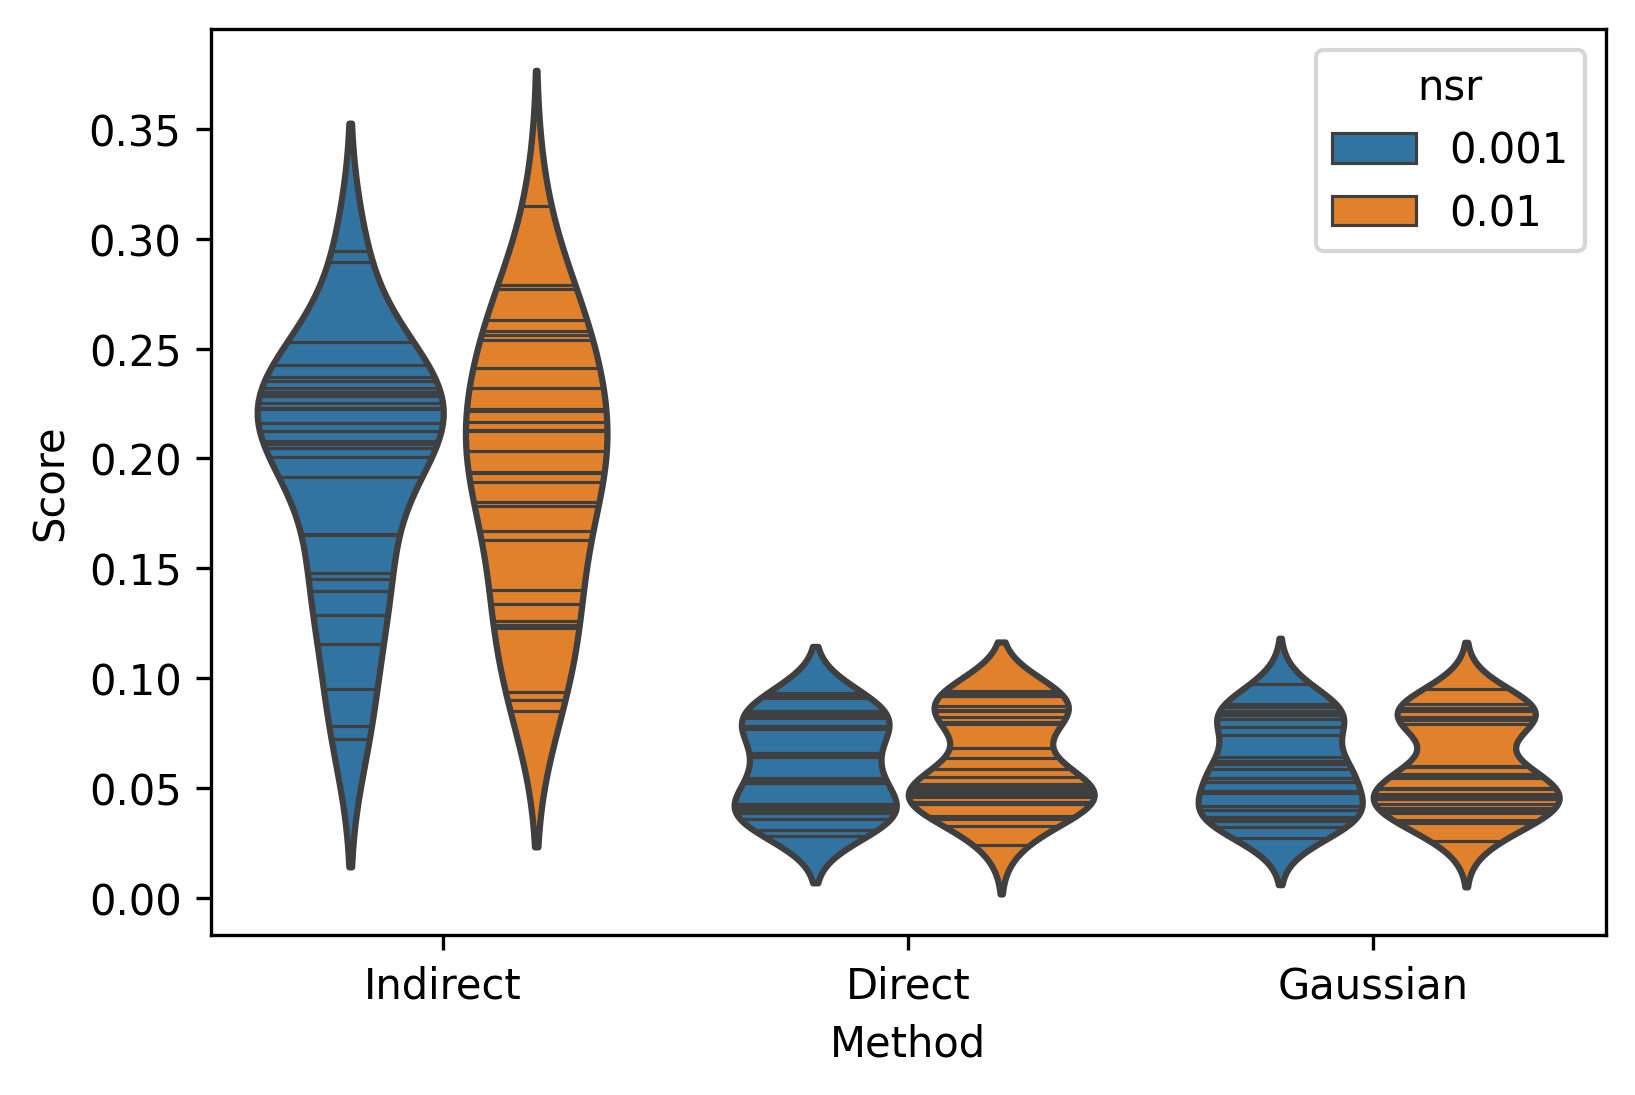

In [86]:
plt.figure(dpi=300)
ax = sns.violinplot(x="Method", y="Score", data=df_plot, inner="stick", hue='nsr')

<Figure size 1800x1200 with 0 Axes>

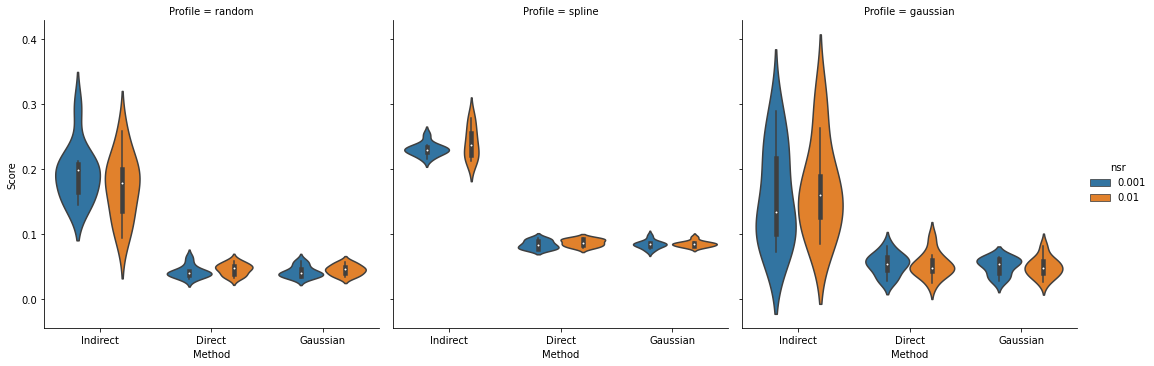

In [87]:
plt.figure(dpi=300)
ax = sns.catplot(x="Method", y="Score", data=df_plot, hue='nsr', col="Profile", kind='violin')

In [ ]:
ax = sns.violinplot(x="Method", y="Score", 
                    data=df_characterization[df_characterization['Profile']=='random', df_characterization['nsr']==0.010,df_characterization['Metric']=='MSE' ])

In [47]:
df_characterizationv1= df_characterization.copy()

In [ ]:
mse_indirect = mean_squared_error(true_profile[1:], indirect)
mse_direct = mean_squared_error(true_profile[1:], direct)
mse_indirect = mean_squared_error(true_profile[1:], indirect)
mse_gaussian = mean_squared_error(true_profile[1:], LOICA_profile[1:])
temp = {'Profile':'p', 'nsr':'n', 'Method':'Indirect', 'Metric':'MSE', 'Score':mse_indirect}
            

In [ ]:
temp

In [ ]:
#Defined data structure
columns = { 'Profile':[], 'nsr':[], 'Method':[], 'Metric':[], 'Score':[] }
df_characterization = pd.DataFrame(columns)
df_characterization

In [ ]:
df_characterization = df_characterization.append([temp, temp], ignore_index=True)
df_characterization

In [ ]:
columns = { 'Frame':[], 'Nuc_Num':[], 'Nuc_Area':[], 'OMM_Num':[], 'OMM_Area':[]}
    mito_df = pd.DataFrame(columns)
    for i in range(t):
        im_omm = im_omm_mask[i,3,:,:] #imagen en el canal c slice 3
        im_nuc = im_nuc_mask[i,3,:,:]
        #ubyte_im = img_as_ubyte(im)
        #segmentation
        binary_rso_omm = remove_small_objects(im_omm, min_size=area_min_omm)
        binary_rso_nuc = remove_small_objects(im_nuc, min_size=area_min_nuc)
        #labeling and number
        labeled_omm, num_omm = ndi.label(binary_rso_omm)
        labeled_nuc, num_nuc = ndi.label(binary_rso_nuc)
        #calculations
        area_tomm = np.sum(binary_rso_omm)*0.002025**2 #this transforms it into um
        area_tnuc = np.sum(binary_rso_nuc)*0.002025**2
        nuc_avg_area = area_tnuc/num_nuc
        omm_avg_area = area_tomm/num_omm
        temp_mito_df = { 'Frame':i+1, 
                        'Nuc_Num':num_nuc, 'Nuc_Area':area_tnuc, 'Nuc_avgArea': nuc_avg_area,
                        'OMM_Num':num_omm, 'OMM_Area':area_tomm, 'OMM_avgArea': omm_avg_area}
        mito_df = mito_df.append(temp_mito_df,ignore_index=True )
    return mito_df

### Here ends the first part

### Receiver

Create a genetic network and associate it with a Flapjack vector:

In [ ]:
dna = fj.get('dna', name='Rec_1e-3_nsr')
if len(dna)==0:
    dna = fj.create('dna', name='Rec_1e-3_nsr')
vector = fj.get('vector', name='Rec_1e-3_nsr')    
if len(vector)==0:
    vector = fj.create('vector', name='Rec_1e-3_nsr', dnas=dna.id)
    
rec = GeneticNetwork(vector=vector.id[0])

Create a reporter and associate it with a Flapjack signal so we can record the behaviour of the circuit:

In [ ]:
cfp = fj.get('signal', name='CFP')
sfp1 = Reporter(name='CFP', degradation_rate=0, init_concentration=1, signal_id=cfp.id[0])

rec.add_reporter(sfp1)

Create and add a receiver operator to the circuit, linking it to an AHL supplement:

In [ ]:
ahl = Supplement(name='AHL')
def sin_profile(t):
    return 1 - np.cos(2 * np.pi * t / 12)
def mu_profile(t):
    return 1 - gompertz_growth_rate(t, 0.01, 1, 1, 4)
rec_profile = random_profile(t0=0, tmax=24, nt=100, fmax=0.05)
rec.add_operator(Receiver(inducer=ahl, output=sfp1, a=0, b=100, K=1, n=2, profile=rec_profile))

Now we have constructed the circuit we need to run an assay containing some samples. The sample is driven by a metabolism which defines the dynamics of growth and gene expression profiles:

In [ ]:
def growth_rate(t):
    return gompertz_growth_rate(t, 0.05, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.05, 1, 1, 1)
    
metab = SimulatedMetabolism(biomass, growth_rate)

Next we create a set of samples associated to Flapjack media and strain, and containing our AHL at different concentrations

In [ ]:
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

# Create list of samples    
samples = []
for conc in np.logspace(-6, 6, 12):
    sample = Sample(circuit=rec, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0])
    # Add AHL to samples at given concentration
    sample.add_supplement(ahl, conc)
    samples.append(sample)

Now we can create and run the assay:

In [ ]:
biomass_signal = fj.get('signal', name='OD')
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica receiver',
              description='Simulated receiver generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=1e-3)

Plot the results:

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].groupby('Sample').plot(x='Time', y='Measurement', style='.', ax=ax)
plt.yscale('log')
len(m)

Upload the simulated data to flapjack

In [ ]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')

assay.upload(fj, study.id[0])

In [ ]:
#vector = fj.get('vector', name='pREC')
#media = fj.get('media', name='Simulated media')
#strain = fj.get('strain', name='Simulated strain')
#signal = fj.get('signal', name='CFP')
#biomass_signal = fj.get('signal', name='OD')
#print(biomass_signal)

signal = fj.get('signal', name='CFP')
vector = fj.get('vector', name='Rec_1e-3_nsr')
media = fj.get('media', name='Loica')
strain = fj.get('strain', name='Loica strain')
cfp = fj.get('signal', name='CFP')
biomass_signal = fj.get('signal', name='OD')
analyte = fj.get('chemical', name='AHL')

char_receiver = Receiver(None, None, 0,0,0,0)
char_receiver.characterize(
    fj,
    vector=vector.id,
    media=media.id,
    strain=strain.id,
    signal=signal.id,
    biomass_signal=biomass_signal.id,
    n_gaussians=20,
    epsilon=0
)

In [ ]:
t = np.linspace(0, 24, 100)
print(f'a = {char_receiver.a}')
print('b = ', char_receiver.b)
print('K = ', char_receiver.K)
print('n = ', char_receiver.n)

plt.plot(t, char_receiver.profile(t))
plt.plot(t, rec_profile(t))
plt.legend(['Characterization', 'True'])

### Inverter

In [ ]:
dna = fj.get('dna', name='Inv_1e-3_nsr')
if len(dna)==0:
    dna = fj.create('dna', name='Inv_1e-3_nsr')
vector = fj.get('vector', name='Inv_1e-3_nsr')    
if len(vector)==0:
    vector = fj.create('vector', name='Inv_1e-3_nsr', dnas=dna.id)
    
inv = GeneticNetwork(vector=vector.id[0])

In [ ]:
def mu_profile(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)
inv_profile = random_profile(t0=0, tmax=24, nt=100, fmax=0.05)

In [ ]:
ahl = Supplement(name='AHL')
laci = Regulator('LacI', degradation_rate=2)
rec = Receiver(inducer=ahl, output=laci, a=0, b=100, K=1, n=2, profile=rec_profile)
inv.add_operator(rec)
inv.add_regulator(laci)

In [ ]:
cfp = fj.get('signal', name='CFP')
cfp = Reporter('CFP', signal_id=cfp.id[0])
inv.add_reporter(cfp)
inv.add_operator(Not(input=laci, output=cfp, a=100, b=0, K=1, n=2, profile=inv_profile))

In [ ]:
# Create list of samples    
samples = []
media = fj.get('media', name='Loica')
strain = fj.get('strain', name='Loica strain')
for conc in np.logspace(-6, 6, 12):
    sample = Sample(circuit=inv, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0])
    # Add AHL to samples at given concentration
    sample.add_supplement(ahl, conc)
    samples.append(sample)

In [ ]:
biomass_signal = fj.get('signal', name='OD')
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica inverter',
              description='Simulated inverter generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', style='.', ax=ax)

In [ ]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')

assay.upload(fj, study.id[0])

In [ ]:
signal = fj.get('signal', name='CFP')
receiver = fj.get('vector', name='Rec_1e-3_nsr')
inverter = fj.get('vector', name='Inv_1e-3_nsr')
media = fj.get('media', name='Loica')
strain = fj.get('strain', name='Loica strain')
biomass_signal = fj.get('signal', name='OD')
analyte = fj.get('chemical', name='AHL')

char_not = Not(input=None, output=None, a=100, b=0, K=1, n=2)
char_not.characterize(
    fj,
    receiver = receiver.id,
    inverter=inverter.id,
    media=media.id,
    strain=strain.id,
    signal=signal.id,
    biomass_signal=biomass_signal.id,
    n_gaussians=20,
    epsilon=0,
    gamma=2
)

In [ ]:
t = np.linspace(0, 24, 100)
plt.plot(t, char_not.profile(t), 'r--')
plt.plot(t, inv_profile(t), 'r')
plt.plot(t, rec_profile(t), 'g')
plt.plot(t, char_not.profile_A(t), 'g--')

print(char_not.a_A, char_not.b_A, char_not.K_A, char_not.n_A)
print(char_not.a, char_not.b, char_not.K, char_not.n) #, char_not.gamma)

In [ ]:
J = char_not.res.jac
H = J.T.dot(J)
C = np.linalg.inv(H) * np.sum(char_not.res.fun*char_not.res.fun) / 100
covar = np.diag(np.abs(C))
std = np.sqrt(covar)
print(std[:3])
print(char_not.n, char_not.K, char_not.b)
plt.imshow(C[:,:]); plt.colorbar()

In [ ]:
means = np.linspace(t.min(), t.max(), 20)
vars = [t.max()/20]*20 #res.x[:n_blobs]

profiles = []
for i in range(1000):
    rheights = np.random.multivariate_normal(char_not.res.x[3:], C[3:,3:])
    profile = np.zeros_like(t)
    for mean,var,height in zip(means, vars, rheights):
        gaussian = height * np.exp(-(t-mean)*(t-mean) / var / 2) / np.sqrt(2 * np.pi * var)
        profile += gaussian
    profiles.append(np.array(profile))
profiles = np.array(profiles)
mean = np.mean(profiles, axis=0)
std = np.std(profiles, axis=0)
plt.plot(t, mean, 'k')
plt.fill_between(t, mean-std, mean+std, color='k', alpha=0.2)

### Repressilator

In [ ]:
dna = fj.get('dna', name='Rep')
if len(dna)==0:
    dna = fj.create('dna', name='Rep')
vector = fj.get('vector', name='Rep')    
if len(vector)==0:
    vector = fj.create('vector', name='Rep', dnas=dna.id)
    
rep = GeneticNetwork(vector=vector.id[0])

In [ ]:
laci = Regulator(name='LacI', degradation_rate=1, init_concentration=5)
tetr = Regulator(name='TetR', degradation_rate=1)
ci = Regulator(name='cI', degradation_rate=1)
rep.add_regulator(laci)
rep.add_regulator(tetr)
rep.add_regulator(ci)

cfp = fj.get('signal', name='CFP')
yfp = fj.get('signal', name='YFP')
rfp = fj.get('signal', name='RFP')

sfp1 = Reporter(name='CFP', degradation_rate=1, signal_id=cfp.id[0])
rep.add_reporter(sfp1)
sfp2 = Reporter(name='YFP', degradation_rate=1, signal_id=yfp.id[0])
rep.add_reporter(sfp2)
sfp3 = Reporter(name='RFP', degradation_rate=1, signal_id=rfp.id[0])
rep.add_reporter(sfp3)

rep.add_operator(Not(input=ci, output=laci, a=100, b=0, K=1, n=2))
rep.add_operator(Not(input=laci, output=tetr, a=100, b=0, K=1, n=2))
rep.add_operator(Not(input=tetr, output=ci, a=100, b=0, K=1, n=2))

rep.add_operator(Not(input=ci, output=sfp1, a=100, b=0, K=1, n=2))
rep.add_operator(Not(input=laci, output=sfp2, a=100, b=0, K=1, n=2))
rep.add_operator(Not(input=tetr, output=sfp3, a=100, b=0, K=1, n=2))

In [ ]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

biomass_signal = fj.get('signal', name='OD')

sample = Sample(circuit=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='Loica repressilator',
              description='Simulated repressilator generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [ ]:
assay.measurements

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', ax=ax)
m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax)
m[m.Signal=='RFP'].plot(x='Time', y='Measurement', ax=ax)

Upload simulated data to flapjack

In [ ]:
assay.upload(fj, study.id[0])

### Toggle switch

In [ ]:
dna = fj.create('dna', name='Toggle')
vector = fj.create('vector', name='Toggle', dnas=dna.id)
tog = GeneticNetwork(vector=vector.id[0])

laci = Regulator(name='LacI', degradation_rate=1, init_concentration=0.1)
ci = Regulator(name='cI', degradation_rate=1)
tog.add_regulator(laci)
tog.add_regulator(ci)

cfp = fj.get('signal', name='CFP')
yfp = fj.get('signal', name='YFP')
sfp1 = Reporter(name='CFP', degradation_rate=1, signal_id=cfp.id[0])
tog.add_reporter(sfp1)
sfp2 = Reporter(name='YFP', degradation_rate=1, signal_id=yfp.id[0])
tog.add_reporter(sfp2)

tog.add_operator(Not(input=laci, output=ci, a=10, b=0, K=1, n=2))
tog.add_operator(Not(input=ci, output=laci, a=10, b=0, K=1, n=2))

tog.add_operator(Not(input=ci, output=sfp1, a=10, b=0, K=1, n=2))
tog.add_operator(Not(input=laci, output=sfp2, a=10, b=0, K=1, n=2))

In [ ]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

biomass_signal = fj.get('signal', name='OD')
sample = Sample(circuit=tog, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='Loica toggle',
              description='Simulated toggle switch generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', ax=ax)
m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax)

Upload simulated data to flapjack

In [ ]:
assay.upload(fj, study.id[0])

### Nor gate

In [ ]:
dna = fj.get('dna', name='Nor')
if len(dna)==0:
    dna = fj.create('dna', name='Nor')
vector = fj.get('vector', name='Nor')    
if len(vector)==0:
    vector = fj.create('vector', name='Nor', dnas=dna.id)
    
nor = GeneticNetwork(vector=vector.id[0])

Create a reporter and associate it with a Flapjack signal so we can record the behaviour of the circuit:

In [ ]:
cfp = fj.get('signal', name='CFP')
sfp1 = Reporter(name='CFP', degradation_rate=0, signal_id=cfp.id[0])

nor.add_reporter(sfp1)

Create and add a receiver operator to the circuit, linking it to an AHL supplement and the receptor we just created:

In [ ]:
ahl1 = Supplement(name='AHL1')
ahl2 = Supplement(name='AHL2')
nor.add_operator(Nor(input=[ahl1, ahl2], output=sfp1, alpha=[0.0001,1,1,1], a=[100,100], b=[1,1], K=[1,1], n=[2,2]))

Now we have constructed the circuit we need to run an assay containing some samples. The sample is driven by a metabolism which defines the dynamics of growth and gene expression profiles:

In [ ]:
def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 4)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 4)
    
metab = SimulatedMetabolism(biomass, growth_rate)

Next we create a set of samples associated to Flapjack media and strain, and containing our AHL at different concentrations

In [ ]:
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

# Create list of samples    
samples = []
for conc1 in np.logspace(-3, 3, 6):
    for conc2 in np.logspace(-3,3,6):
        sample = Sample(circuit=nor, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0])
        # Add AHL to samples at given concentration
        sample.add_supplement(ahl1, conc1)
        sample.add_supplement(ahl2, conc2)
        samples.append(sample)

Now we can create and run the assay:

In [ ]:
biomass_signal = fj.get('signal', name='OD')
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.25,
              name='Loica nor',
              description='Simulated nor generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

Plot the results:

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', style='.', ax=ax)

Upload the simulated data to flapjack

In [ ]:
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')

assay.upload(fj, study.id[0])